# Convolve 3.0

## Problem Statement:

You have been provided with a random sample of **96,806** Credit Card details in  
“Dev_data_to_be_shared.zip”, along with a flag **(bad_flag)** henceforth known as “development 
data”.<br>
This is a historical snapshot of the Credit Card portfolio of Bank A. <br>
**Credit Cards that have actually defaulted have bad_flag = 1.**<br>
You have also been provided with several independent variables.<br>

These include: <br>
- On us attributes like credit limit (varables with names starting with onus_attributes) 
- Transaction level attributes like number of transactions / rupee value transactions on 
various kinds of merchants (variables with names starting with transaction_attribute) 
- Bureau tradeline level attributes (like product holdings, historical delinquencies) – variables 
starting with bureau 
- Bureau enquiry level attributes (like PL enquiries in the last 3 months etc) – variables 
starting with bureau_enquiry.

You have also been provided with another random sample of 41,792 Credit Card details in “validation_data_to_be_shared.zip” with the same set of input variables, but without “bad_flag”. <br>
This will be referred to going forward as “validation data”.

**Your objective is to develop the **Behaviour Score** for Bank A.**

Bank A issues Credit Cards to eligible customers. The Bank deploys advanced ML models and frameworks to decide on eligibility, limit, and interest rate assignment. <br>
The models and frameworks are optimized to manage early risk and ensure profitability.  <br>
The Bank has now decided to build a robust risk management framework for its existing Credit Card customers, irrespective of when they were acquired. <br>
To enable this, the Bank has decided to create a **“Behaviour Score”**. A Behaviour Score is a predictive model. It is developed on a base of customers whose Credit Cards are **open** and are **not past due**. <br>
<br><br>
The model predicts the probability of customers defaulting on the Credit Cards going forward. <br><br>
This model will then be used for several portfolio risk management activities

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

## EDA

### Read the dataset from the filesystem

In [41]:
card_data = pd.read_csv('./data/Dev_data_to_be_shared.csv')

In [42]:
print(card_data.shape)
card_data.head()

(96806, 1216)


,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
X = card_data.drop('bad_flag', axis = 1)
y = card_data['bad_flag']

In [44]:
# Collect columns starting with 'onus', 'transaction', and 'bureau' in separate variables
onus_attr_X = X.filter(like='onus_attribute')
transaction_attr_X = X.filter(like='transaction_attribute')
bureau_attr_X = X.filter(like='bureau')

# Combine the selected columns into a single DataFrame
X_selected = pd.concat([onus_attr_X, transaction_attr_X, bureau_attr_X], axis=1)

# Print the shape of the new DataFrame
print(X_selected.shape)
print(X.shape)
print(onus_attr_X.shape, transaction_attr_X.shape, bureau_attr_X.shape)

(96806, 1214)
(96806, 1215)
(96806, 48) (96806, 664) (96806, 502)


In [45]:
# Concatenate y with the selected attributes
y_onus_attr_X = pd.concat([y, onus_attr_X], axis=1)
y_transaction_attr_X = pd.concat([y, transaction_attr_X], axis=1)
y_bureau_attr_X = pd.concat([y, bureau_attr_X], axis=1)

# Calculate correlation matrix for each DataFrame
corr_onus_attr_X = y_onus_attr_X.corr()
corr_transaction_attr_X = y_transaction_attr_X.corr()
corr_bureau_attr_X = y_bureau_attr_X.corr()

<Axes: >

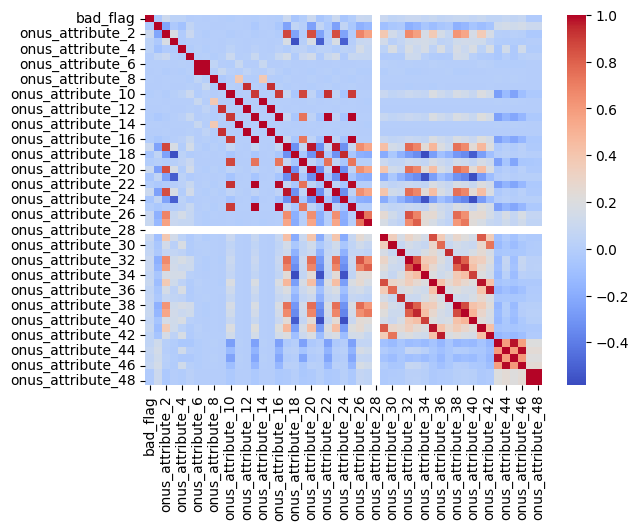

In [46]:
sns.heatmap(corr_onus_attr_X, cmap='coolwarm', annot=False)

<Axes: >

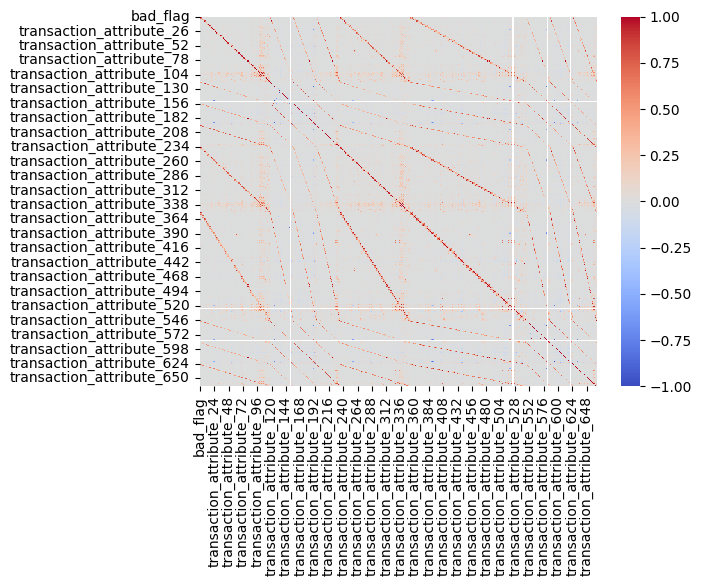

In [47]:
sns.heatmap(corr_transaction_attr_X, cmap='coolwarm', annot=False)

<Axes: >

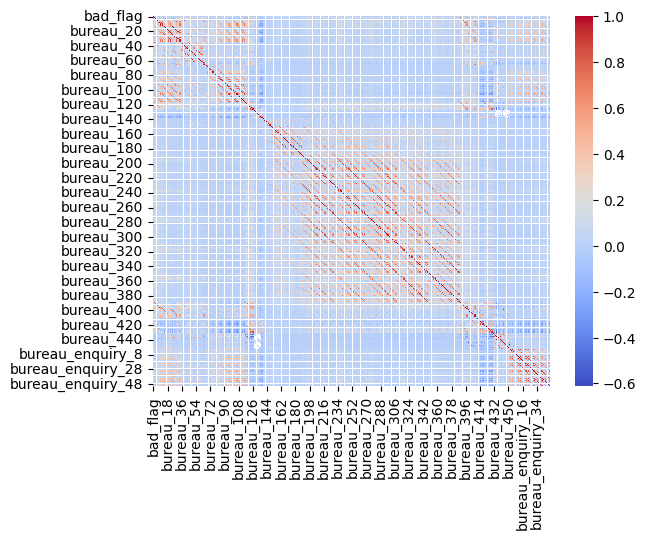

In [48]:
sns.heatmap(corr_bureau_attr_X, cmap='coolwarm', annot=False)

<Axes: >

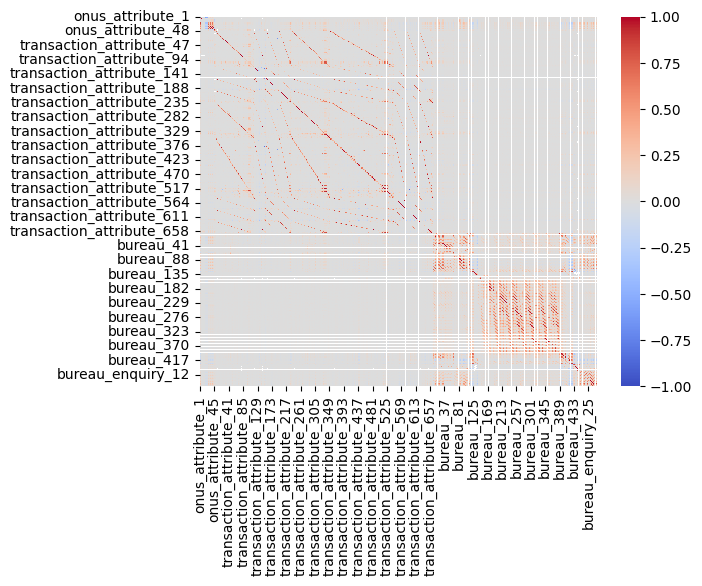

In [50]:
sns.heatmap(X_selected.corr(), cmap='coolwarm', annot=False)

In [55]:
# Calculate mean, std deviation, min, max, sum, and total NaN count for onus attributes
onus_attr_stats = onus_attr_X.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
onus_attr_stats['NaN_count'] = onus_attr_X.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for transaction attributes
transaction_attr_stats = transaction_attr_X.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
transaction_attr_stats['NaN_count'] = transaction_attr_X.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for bureau attributes
bureau_attr_stats = bureau_attr_X.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
bureau_attr_stats['NaN_count'] = bureau_attr_X.isnull().sum()

In [56]:
onus_attr_stats

,mean,std,min,max,sum,count,NaN_count
onus_attribute_1,154239.119804,172992.463938,2.500000e+04,2.800000e+06,1.103966e+10,71575.0,25231
onus_attribute_2,0.223953,0.315112,-1.090172e+00,1.243536e+00,2.167998e+04,96806.0,0
onus_attribute_3,0.004442,0.066500,0.000000e+00,1.000000e+00,4.300000e+02,96806.0,0
onus_attribute_4,0.104208,0.305532,0.000000e+00,1.000000e+00,1.008800e+04,96806.0,0
onus_attribute_5,13651.141877,75221.873832,0.000000e+00,1.449062e+07,1.321485e+09,96804.0,2
onus_attribute_6,-1297.654162,63147.976037,-8.836500e+06,5.834018e+06,-7.934247e+07,61143.0,35663
onus_attribute_7,142.367293,5745.204946,-1.290306e-03,7.256470e+05,7.382029e+06,51852.0,44954
onus_attribute_8,-107.851063,7836.379603,-1.622450e+06,9.395292e+04,-7.395132e+06,68568.0,28238
onus_attribute_9,39.836408,2549.249120,-2.823981e-03,5.811266e+05,2.644142e+06,66375.0,30431
onus_attribute_10,2.341711,0.815396,1.000000e+00,4.000000e+00,2.266870e+05,96804.0,2


In [57]:
transaction_attr_stats

,mean,std,min,max,sum,count,NaN_count
transaction_attribute_1,9.570769,1513.967595,0.000000,398936.791000,6.850278e+05,71575.0,25231
transaction_attribute_2,0.002207,0.119240,0.000000,25.000000,1.580000e+02,71575.0,25231
transaction_attribute_3,4.092854,301.580599,0.000000,55000.000000,2.929460e+05,71575.0,25231
transaction_attribute_4,77.306435,3164.987013,-109800.476600,358986.000000,5.533208e+06,71575.0,25231
transaction_attribute_5,0.006315,0.129545,0.000000,12.000000,4.520000e+02,71575.0,25231
...,...,...,...,...,...,...,...
transaction_attribute_660,0.272400,0.734516,-0.351142,129.879402,1.949704e+04,71575.0,25231
transaction_attribute_661,0.146834,0.598994,-0.500000,93.688219,1.050963e+04,71575.0,25231
transaction_attribute_662,0.000604,0.016403,-0.114195,2.313612,4.324906e+01,71575.0,25231
transaction_attribute_663,0.009424,0.035514,0.000000,1.032983,6.745454e+02,71575.0,25231


In [58]:
bureau_attr_stats

,mean,std,min,max,sum,count,NaN_count
bureau_1,0.384948,0.981034,0.0,76.0,36806.0,95613.0,1193
bureau_2,2.103406,3.647110,0.0,91.0,201113.0,95613.0,1193
bureau_3,0.402759,0.948211,0.0,25.0,38509.0,95613.0,1193
bureau_4,0.000000,0.000000,0.0,0.0,0.0,95613.0,1193
bureau_5,0.486461,0.868490,0.0,15.0,46512.0,95613.0,1193
...,...,...,...,...,...,...,...
bureau_enquiry_46,0.455908,1.232560,0.0,43.0,42952.0,94212.0,2594
bureau_enquiry_47,0.000000,0.000000,0.0,0.0,0.0,94212.0,2594
bureau_enquiry_48,0.189657,0.597298,0.0,18.0,17868.0,94212.0,2594
bureau_enquiry_49,0.044283,0.369451,0.0,14.0,4172.0,94212.0,2594


Handling NaN Values using mean imputation

In [60]:
num_imputer = SimpleImputer(strategy='mean')

numerical_columns = X_selected.select_dtypes(include=[np.number]).columns
X_selected[numerical_columns] = num_imputer.fit_transform(X_selected[numerical_columns])

X_selected.shape

/Users/vedantjoshi/Documents/Python journey/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['bureau_436' 'bureau_447']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


ValueError: Columns must be same length as key